In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('../data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import random
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from image_training_utils import *

# import image_training_utils
# importlib.reload(image_training_utils)
# from image_training_utils import *

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a couple different labels (*povo* and *categoria*) and study how they affect the generated emebdding space.

In [4]:
# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open('../'+row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [5]:
# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
vit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
povo_labels, povo_name_to_num, povo_num_to_name = preparing_image_labels(ind_df, 'povo')
povo_dataset = ImageDataset(povo_labels, transform=vit_transform, augment=False)

In [6]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from transformers import ViTModel

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
povo_dataloader = DataLoader(povo_dataset, batch_size=512, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, vanilla_image_indices = get_embeddings(model, povo_dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)
vanilla_image_indices = np.concatenate(vanilla_image_indices, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [03:00<00:00,  7.83s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [7]:
# Creating our own ViT classifier (multi-)head for fine-tuning
class ViTClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier1 = nn.Linear(self.vit.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.vit.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [8]:
# Studying data distribution to filter out rare classes
povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(povo_labels)

# Filtering classes so that we retain around 85% of data
povo_filtered_categories = {}
povo_filtered_categories_names = {}
for c in masks[3][0]:
    povo_filtered_categories[categories_keys[c]] = povo_categories[categories_keys[c]]
    
    povo_filtered_categories_names[povo_num_to_name[categories_keys[c]]] = \
    povo_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [9]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            vit_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

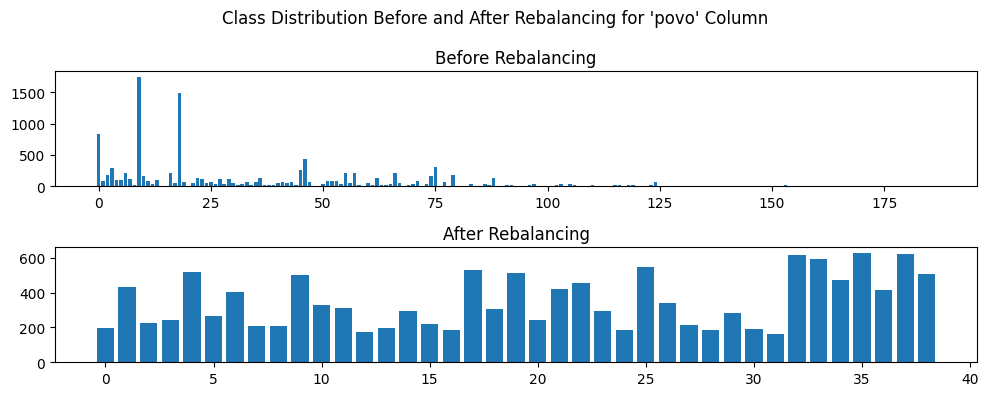

In [10]:
# Plotting old and new class distributions
plot_class_distributions(povo_categories, povo_filtered_categories, labels_minority, \
                         labels_majority, threshold_multiplier, 'povo')

In [11]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
povo_class_weights = compute_class_weights(povo_filtered_categories, labels_minority, \
                                           labels_majority, device, threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:12<1:19:52, 252.25s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1105.0194, Validation Accuracy: 0.3665


Training model:  10%|████▌                                        | 2/20 [08:21<1:15:12, 250.71s/it]

Best model saved at epoch 2
Epoch 2, Loss: 805.4055, Validation Accuracy: 0.4739


Training model:  15%|██████▊                                      | 3/20 [12:30<1:10:44, 249.67s/it]

Best model saved at epoch 3
Epoch 3, Loss: 610.7271, Validation Accuracy: 0.5369


Training model:  20%|█████████                                    | 4/20 [16:36<1:06:12, 248.26s/it]

Best model saved at epoch 4
Epoch 4, Loss: 447.2005, Validation Accuracy: 0.5872


Training model:  25%|███████████▎                                 | 5/20 [20:41<1:01:49, 247.27s/it]

Best model saved at epoch 5
Epoch 5, Loss: 311.7768, Validation Accuracy: 0.6286


Training model:  30%|██████████████                                 | 6/20 [24:47<57:34, 246.77s/it]

Best model saved at epoch 6
Epoch 6, Loss: 208.0585, Validation Accuracy: 0.6591


Training model:  35%|████████████████▍                              | 7/20 [28:48<53:00, 244.68s/it]

Epoch 7, Loss: 136.4552, Validation Accuracy: 0.6542


Training model:  40%|██████████████████▊                            | 8/20 [32:48<48:40, 243.39s/it]

Best model saved at epoch 8
Epoch 8, Loss: 90.3738, Validation Accuracy: 0.6611


Training model:  45%|█████████████████████▏                         | 9/20 [36:49<44:29, 242.72s/it]

Best model saved at epoch 9
Epoch 9, Loss: 60.5071, Validation Accuracy: 0.6650


Training model:  50%|███████████████████████                       | 10/20 [40:50<40:19, 241.94s/it]

Epoch 10, Loss: 40.7643, Validation Accuracy: 0.6631


Training model:  55%|█████████████████████████▎                    | 11/20 [44:50<36:14, 241.56s/it]

Best model saved at epoch 11
Epoch 11, Loss: 28.8275, Validation Accuracy: 0.6729


Training model:  60%|███████████████████████████▌                  | 12/20 [48:54<32:17, 242.23s/it]

Best model saved at epoch 12
Epoch 12, Loss: 20.3957, Validation Accuracy: 0.6749


Training model:  65%|█████████████████████████████▉                | 13/20 [53:03<28:30, 244.32s/it]

Epoch 13, Loss: 15.0493, Validation Accuracy: 0.6709


Training model:  70%|████████████████████████████████▏             | 14/20 [57:13<24:35, 245.98s/it]

Epoch 14, Loss: 11.8458, Validation Accuracy: 0.6709


Training model:  75%|█████████████████████████████████           | 15/20 [1:01:25<20:39, 247.85s/it]

Epoch 15, Loss: 14.0964, Validation Accuracy: 0.6010


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:05:34<16:32, 248.22s/it]

Epoch 16, Loss: 69.6110, Validation Accuracy: 0.6493


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:09:42<17:25, 261.44s/it]


Early-stopping training!


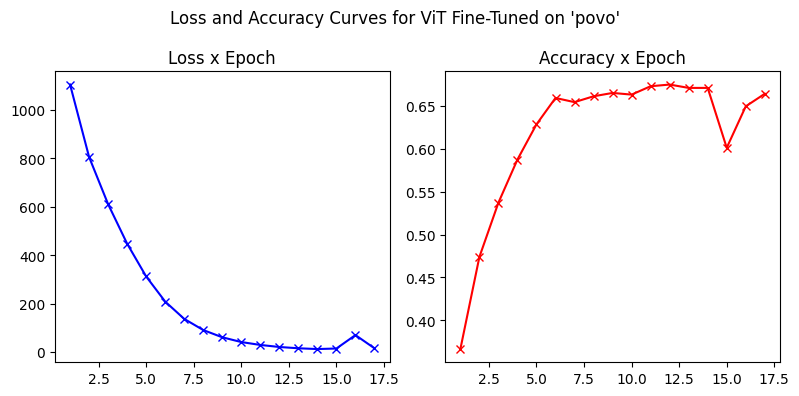

Validation accuracy: 0.6748046875
Validation average per class precision: 0.2644
Validation average per class recall: 0.2606



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.6663708686828613
Test average per class precision: 0.2824
Test average per class recall: 0.2514

Test average precision on filtered classes: 0.5875204656368647
Test average recall on filtered classes: 0.6606162652755395


In [12]:
# Recreating datasets for proper training and testing
povo_train_val_labels = povo_labels.copy()
povo_test_labels_aux = random.sample(list(povo_train_val_labels), \
                                     int(0.1*len(povo_train_val_labels)))
povo_test_labels = {}
for key in povo_test_labels_aux:
    povo_test_labels[key] = povo_train_val_labels[key]
    del povo_train_val_labels[key]
    
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=vit_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=2e-6)
model_name = 'vit_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                         batch_size, epochs, num_classes, model, criterion, \
                                         opt, model_name, column_name)
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [06:59<2:12:53, 419.64s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1388.4725, Validation Accuracy: 0.3881


Training model:  10%|████▌                                        | 2/20 [13:57<2:05:30, 418.37s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1058.7765, Validation Accuracy: 0.5086


Training model:  15%|██████▊                                      | 3/20 [20:46<1:57:19, 414.10s/it]

Best model saved at epoch 3
Epoch 3, Loss: 749.3905, Validation Accuracy: 0.5822


Training model:  20%|█████████                                    | 4/20 [27:39<1:50:18, 413.68s/it]

Best model saved at epoch 4
Epoch 4, Loss: 456.2853, Validation Accuracy: 0.6416


Training model:  25%|███████████▎                                 | 5/20 [34:29<1:43:05, 412.40s/it]

Best model saved at epoch 5
Epoch 5, Loss: 234.5567, Validation Accuracy: 0.6745


Training model:  30%|█████████████▌                               | 6/20 [41:18<1:36:00, 411.45s/it]

Best model saved at epoch 6
Epoch 6, Loss: 111.1401, Validation Accuracy: 0.6948


Training model:  35%|███████████████▋                             | 7/20 [48:11<1:29:13, 411.84s/it]

Best model saved at epoch 7
Epoch 7, Loss: 57.7726, Validation Accuracy: 0.6995


Training model:  40%|██████████████████                           | 8/20 [55:04<1:22:26, 412.24s/it]

Epoch 8, Loss: 39.6757, Validation Accuracy: 0.6714


Training model:  45%|███████████████████▎                       | 9/20 [1:01:54<1:15:25, 411.39s/it]

Epoch 9, Loss: 30.7187, Validation Accuracy: 0.6995


Training model:  50%|█████████████████████                     | 10/20 [1:08:50<1:08:48, 412.83s/it]

Best model saved at epoch 10
Epoch 10, Loss: 18.2643, Validation Accuracy: 0.7011


Training model:  55%|███████████████████████                   | 11/20 [1:15:42<1:01:54, 412.75s/it]

Epoch 11, Loss: 13.6257, Validation Accuracy: 0.6933


Training model:  60%|██████████████████████████▍                 | 12/20 [1:22:35<55:02, 412.83s/it]

Epoch 12, Loss: 19.0426, Validation Accuracy: 0.6808


Training model:  65%|████████████████████████████▌               | 13/20 [1:29:26<48:05, 412.16s/it]

Epoch 13, Loss: 13.4459, Validation Accuracy: 0.6870


Training model:  65%|████████████████████████████▌               | 13/20 [1:36:15<51:49, 444.25s/it]


Early-stopping training!


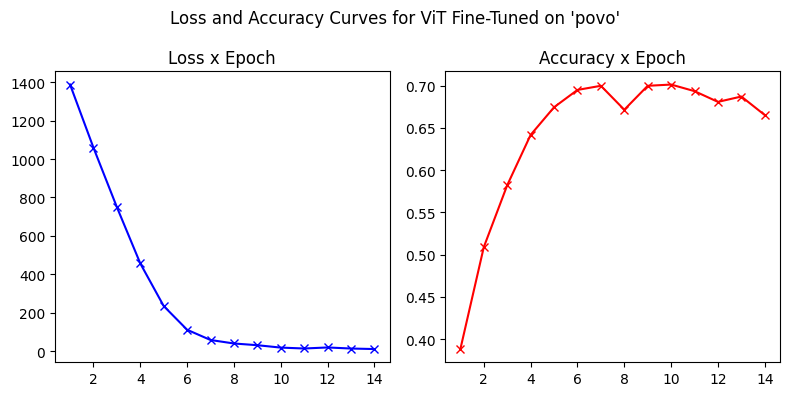

Validation accuracy: 0.701171875
Validation average per class precision: 0.7140
Validation average per class recall: 0.6622

Test accuracy: 0.7177700400352478
Test average per class precision: 0.7050
Test average per class recall: 0.6723



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:48<00:00,  7.34s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                  device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [05:36<1:46:32, 336.47s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1429.9783, Validation Accuracy: 0.3505


Training model:  10%|████▌                                        | 2/20 [11:07<1:40:02, 333.48s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1152.0344, Validation Accuracy: 0.4429


Training model:  15%|██████▊                                      | 3/20 [16:39<1:34:11, 332.43s/it]

Best model saved at epoch 3
Epoch 3, Loss: 890.2067, Validation Accuracy: 0.5446


Training model:  20%|█████████                                    | 4/20 [22:10<1:28:32, 332.04s/it]

Best model saved at epoch 4
Epoch 4, Loss: 628.7903, Validation Accuracy: 0.5978


Training model:  25%|███████████▎                                 | 5/20 [27:43<1:23:03, 332.22s/it]

Best model saved at epoch 5
Epoch 5, Loss: 392.4097, Validation Accuracy: 0.6510


Training model:  30%|█████████████▌                               | 6/20 [33:11<1:17:14, 331.01s/it]

Best model saved at epoch 6
Epoch 6, Loss: 213.0525, Validation Accuracy: 0.6776


Training model:  35%|███████████████▋                             | 7/20 [38:39<1:11:30, 330.07s/it]

Best model saved at epoch 7
Epoch 7, Loss: 107.8248, Validation Accuracy: 0.6823


Training model:  40%|██████████████████                           | 8/20 [44:09<1:06:00, 330.03s/it]

Epoch 8, Loss: 58.4348, Validation Accuracy: 0.6761


Training model:  45%|████████████████████▎                        | 9/20 [49:41<1:00:36, 330.57s/it]

Best model saved at epoch 9
Epoch 9, Loss: 35.5812, Validation Accuracy: 0.6886


Training model:  50%|███████████████████████                       | 10/20 [55:11<55:03, 330.33s/it]

Epoch 10, Loss: 24.3305, Validation Accuracy: 0.6886


Training model:  55%|████████████████████████▏                   | 11/20 [1:00:39<49:28, 329.79s/it]

Epoch 11, Loss: 17.3407, Validation Accuracy: 0.6886


Training model:  60%|██████████████████████████▍                 | 12/20 [1:06:07<43:54, 329.27s/it]

Epoch 12, Loss: 12.8718, Validation Accuracy: 0.6870


Training model:  65%|████████████████████████████▌               | 13/20 [1:11:39<38:30, 330.02s/it]

Best model saved at epoch 13
Epoch 13, Loss: 10.8268, Validation Accuracy: 0.6901


Training model:  70%|██████████████████████████████▊             | 14/20 [1:17:10<33:01, 330.20s/it]

Epoch 14, Loss: 7.4332, Validation Accuracy: 0.6870


Training model:  75%|█████████████████████████████████           | 15/20 [1:22:43<27:35, 331.14s/it]

Best model saved at epoch 15
Epoch 15, Loss: 6.1443, Validation Accuracy: 0.6933


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:28:14<22:03, 330.96s/it]

Epoch 16, Loss: 5.2203, Validation Accuracy: 0.6839


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:33:45<16:32, 330.92s/it]

Epoch 17, Loss: 3.4941, Validation Accuracy: 0.6870


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:39:15<11:01, 330.80s/it]

Epoch 18, Loss: 2.7756, Validation Accuracy: 0.6808


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:44:47<05:31, 331.20s/it]

Epoch 19, Loss: 2.1470, Validation Accuracy: 0.6854


Training model: 100%|████████████████████████████████████████████| 20/20 [1:50:14<00:00, 330.74s/it]

Epoch 20, Loss: 1.7628, Validation Accuracy: 0.6839


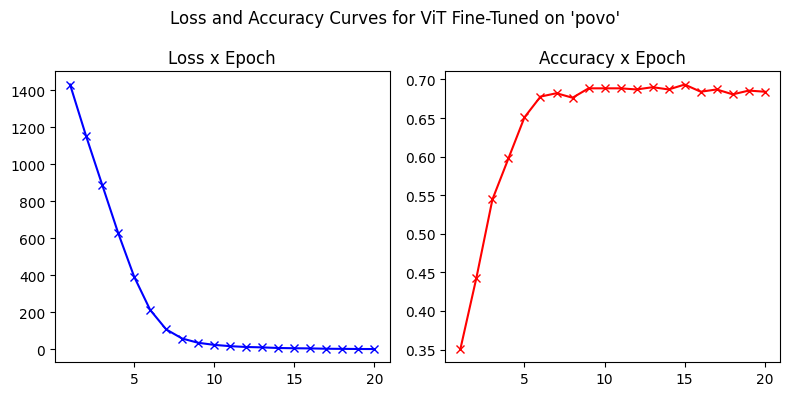

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.693359375
Validation average per class precision: 0.7066
Validation average per class recall: 0.6486

Test accuracy: 0.7299651503562927
Test average per class precision: 0.7012
Test average per class recall: 0.6632



In [14]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [15]:
# Now rebalancing the 'categoria' column
categoria_labels, categoria_name_to_num, categoria_num_to_name = \
preparing_image_labels(ind_df, 'categoria')
categoria_dataset = ImageDataset(categoria_labels, transform=vit_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=512, shuffle=True, \
                                  num_workers=0, pin_memory=True)

categoria_categories, categories_keys, categories_freq, qs, \
masks = study_class_distribution(categoria_labels)

# Filtering out 'etnobotânica' (and 'armas')
filter_out = [categoria_name_to_num['etnobotânica']]
categoria_filtered_categories = {}
categoria_filtered_categories_names = {}
for c in set(categoria_name_to_num.values()) - set(filter_out):
    categoria_filtered_categories[categories_keys[c]] = \
    categoria_categories[categories_keys[c]]
    
    categoria_filtered_categories_names[categoria_num_to_name[categories_keys[c]]] = \
    categoria_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 216.60, 99.71% of data
Q-25: 507.50, 93.33% of data
Q-50: 1060.50, 79.68% of data
Q-75: 1344.50, 58.09% of data
Q-90: 2270.70, 26.50% of data



In [16]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, val_labels, \
test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, vit_transform, \
                               threshold_multiplier, 'categoria')

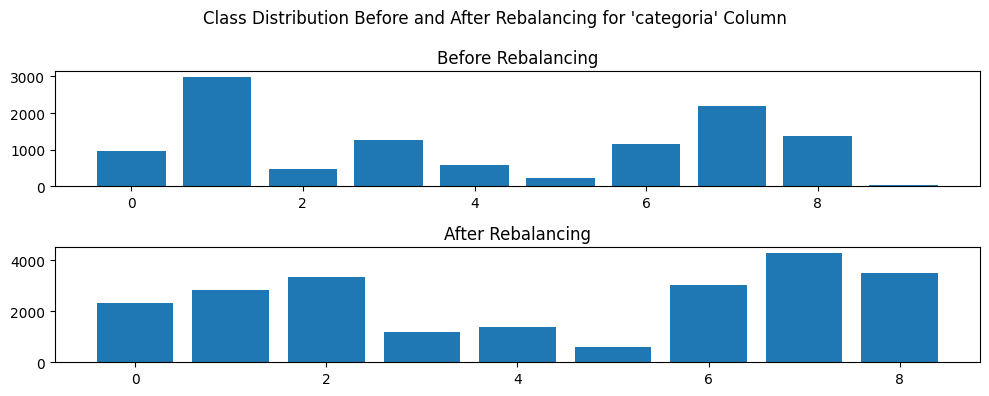

In [17]:
# Plotting old and new class distributions
plot_class_distributions(categoria_categories, categoria_filtered_categories, \
                         labels_minority, labels_majority, threshold_multiplier, 'categoria')

In [18]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
categoria_class_weights = compute_class_weights(categoria_filtered_categories, \
                                                labels_minority, labels_majority, device, \
                                                threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:09<1:19:09, 249.95s/it]

Best model saved at epoch 1
Epoch 1, Loss: 477.2671, Validation Accuracy: 0.6236


Training model:  10%|████▌                                        | 2/20 [08:14<1:14:03, 246.86s/it]

Best model saved at epoch 2
Epoch 2, Loss: 299.5705, Validation Accuracy: 0.7596


Training model:  15%|██████▊                                      | 3/20 [12:19<1:09:40, 245.93s/it]

Best model saved at epoch 3
Epoch 3, Loss: 210.9197, Validation Accuracy: 0.8207


Training model:  20%|█████████                                    | 4/20 [16:24<1:05:27, 245.48s/it]

Best model saved at epoch 4
Epoch 4, Loss: 150.8352, Validation Accuracy: 0.8473


Training model:  25%|███████████▎                                 | 5/20 [20:29<1:01:19, 245.31s/it]

Best model saved at epoch 5
Epoch 5, Loss: 108.9985, Validation Accuracy: 0.8660


Training model:  30%|██████████████                                 | 6/20 [24:34<57:11, 245.14s/it]

Best model saved at epoch 6
Epoch 6, Loss: 77.5500, Validation Accuracy: 0.8719


Training model:  35%|████████████████▍                              | 7/20 [28:37<53:00, 244.62s/it]

Epoch 7, Loss: 57.0810, Validation Accuracy: 0.8631


Training model:  40%|██████████████████▊                            | 8/20 [32:41<48:52, 244.41s/it]

Epoch 8, Loss: 43.7974, Validation Accuracy: 0.8709


Training model:  45%|█████████████████████▏                         | 9/20 [36:46<44:50, 244.58s/it]

Best model saved at epoch 9
Epoch 9, Loss: 35.9010, Validation Accuracy: 0.8788


Training model:  50%|███████████████████████                       | 10/20 [40:50<40:42, 244.26s/it]

Epoch 10, Loss: 27.2025, Validation Accuracy: 0.8719


Training model:  55%|█████████████████████████▎                    | 11/20 [44:54<36:37, 244.21s/it]

Epoch 11, Loss: 23.8783, Validation Accuracy: 0.8571


Training model:  60%|███████████████████████████▌                  | 12/20 [48:57<32:31, 243.98s/it]

Epoch 12, Loss: 20.7137, Validation Accuracy: 0.8768


Training model:  65%|█████████████████████████████▉                | 13/20 [53:00<28:26, 243.75s/it]

Epoch 13, Loss: 20.1540, Validation Accuracy: 0.8700


Training model:  70%|████████████████████████████████▏             | 14/20 [57:04<24:22, 243.68s/it]

Epoch 14, Loss: 17.4333, Validation Accuracy: 0.8768


Training model:  75%|█████████████████████████████████           | 15/20 [1:01:08<20:19, 243.95s/it]

Best model saved at epoch 15
Epoch 15, Loss: 12.6123, Validation Accuracy: 0.8897


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:05:12<16:15, 243.93s/it]

Epoch 16, Loss: 10.6678, Validation Accuracy: 0.8877


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:09:16<12:11, 243.73s/it]

Epoch 17, Loss: 9.0358, Validation Accuracy: 0.8887


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:13:20<08:07, 243.83s/it]

Epoch 18, Loss: 7.8845, Validation Accuracy: 0.8847


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:17:23<04:03, 243.73s/it]

Epoch 19, Loss: 7.2465, Validation Accuracy: 0.8778


Training model: 100%|████████████████████████████████████████████| 20/20 [1:21:27<00:00, 244.38s/it]

Epoch 20, Loss: 19.1542, Validation Accuracy: 0.8847


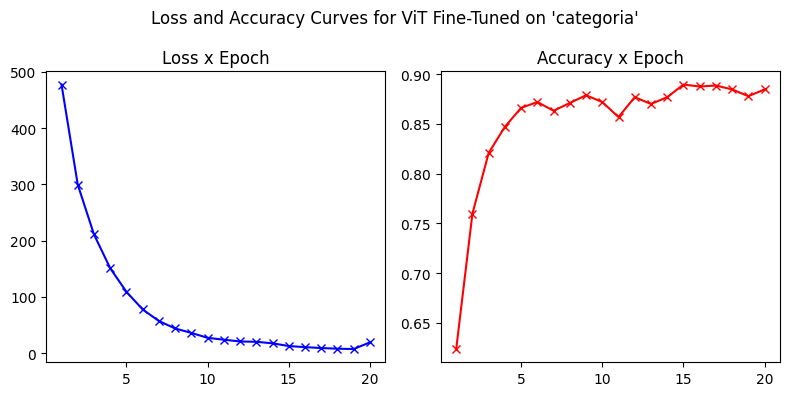

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.8896484375
Validation average per class precision: 0.7956
Validation average per class recall: 0.7858

Test accuracy: 0.8731144666671753
Test average per class precision: 0.7589
Test average per class recall: 0.7659

Test average precision on filtered classes: 0.8432254857487149
Test average recall on filtered classes: 0.8510202831692166


In [19]:
# Recreating datasets for proper training and testing
categoria_train_val_labels = categoria_labels.copy()
categoria_test_labels_aux = random.sample(list(categoria_train_val_labels), \
                                          int(0.1*len(categoria_train_val_labels)))
categoria_test_labels = {}
for key in categoria_test_labels_aux:
    categoria_test_labels[key] = categoria_train_val_labels[key]
    del categoria_train_val_labels[key]
    
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=vit_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, \
                                      transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'vit_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name)
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [11:33<3:39:39, 693.67s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2449.3465, Validation Accuracy: 0.7167


Training model:  10%|████▌                                        | 2/20 [23:15<3:29:29, 698.29s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1456.8886, Validation Accuracy: 0.8068


Training model:  15%|██████▊                                      | 3/20 [35:00<3:18:48, 701.70s/it]

Best model saved at epoch 3
Epoch 3, Loss: 973.2763, Validation Accuracy: 0.8408


Training model:  20%|█████████                                    | 4/20 [46:36<3:06:26, 699.18s/it]

Best model saved at epoch 4
Epoch 4, Loss: 668.3843, Validation Accuracy: 0.8786


Training model:  25%|███████████▎                                 | 5/20 [58:12<2:54:30, 698.06s/it]

Epoch 5, Loss: 462.4048, Validation Accuracy: 0.8767


Training model:  30%|████████████▉                              | 6/20 [1:09:36<2:41:45, 693.23s/it]

Best model saved at epoch 6
Epoch 6, Loss: 316.8314, Validation Accuracy: 0.9016


Training model:  35%|███████████████                            | 7/20 [1:21:06<2:30:00, 692.36s/it]

Epoch 7, Loss: 220.9791, Validation Accuracy: 0.8951


Training model:  40%|█████████████████▏                         | 8/20 [1:32:40<2:18:35, 692.92s/it]

Epoch 8, Loss: 156.3687, Validation Accuracy: 0.8924


Training model:  45%|███████████████████▎                       | 9/20 [1:44:01<2:06:20, 689.17s/it]

Epoch 9, Loss: 111.3279, Validation Accuracy: 0.8979


Training model:  50%|█████████████████████                     | 10/20 [1:55:19<1:54:15, 685.57s/it]

Epoch 10, Loss: 86.0347, Validation Accuracy: 0.8942


Training model:  55%|███████████████████████                   | 11/20 [2:06:42<1:42:43, 684.88s/it]

Epoch 11, Loss: 65.0620, Validation Accuracy: 0.9006


Training model:  60%|█████████████████████████▏                | 12/20 [2:18:07<1:31:18, 684.83s/it]

Epoch 12, Loss: 51.2209, Validation Accuracy: 0.8988


Training model:  65%|███████████████████████████▎              | 13/20 [2:29:33<1:19:56, 685.21s/it]

Best model saved at epoch 13
Epoch 13, Loss: 42.6880, Validation Accuracy: 0.9034


Training model:  70%|█████████████████████████████▍            | 14/20 [2:40:58<1:08:30, 685.03s/it]

Best model saved at epoch 14
Epoch 14, Loss: 37.6054, Validation Accuracy: 0.9071


Training model:  75%|█████████████████████████████████           | 15/20 [2:52:24<57:06, 685.36s/it]

Epoch 15, Loss: 29.8068, Validation Accuracy: 0.8988


Training model:  80%|███████████████████████████████████▏        | 16/20 [3:03:47<45:39, 684.75s/it]

Epoch 16, Loss: 27.2903, Validation Accuracy: 0.8960


Training model:  85%|█████████████████████████████████████▍      | 17/20 [3:15:10<34:12, 684.26s/it]

Epoch 17, Loss: 27.2717, Validation Accuracy: 0.8997


Training model:  90%|███████████████████████████████████████▌    | 18/20 [3:26:33<22:47, 683.90s/it]

Epoch 18, Loss: 20.4917, Validation Accuracy: 0.9052


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [3:37:53<11:22, 682.72s/it]

Epoch 19, Loss: 17.6190, Validation Accuracy: 0.9043


Training model: 100%|████████████████████████████████████████████| 20/20 [3:49:16<00:00, 687.83s/it]


Epoch 20, Loss: 18.9237, Validation Accuracy: 0.9071


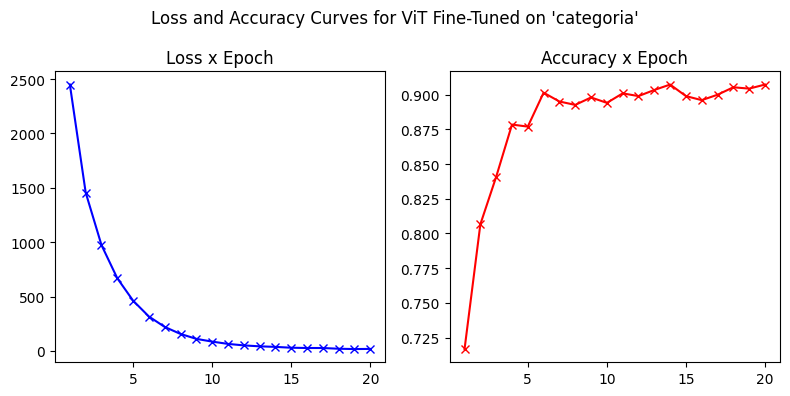

Validation accuracy: 0.9072265625
Validation average per class precision: 0.8869
Validation average per class recall: 0.8857

Test accuracy: 0.8568507432937622
Test average per class precision: 0.8566
Test average per class recall: 0.8340



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:47<00:00,  7.29s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [20]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap, \
categoria_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [08:53<2:48:53, 533.35s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2692.7399, Validation Accuracy: 0.6615


Training model:  10%|████▌                                        | 2/20 [17:53<2:41:17, 537.64s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1850.8123, Validation Accuracy: 0.7397


Training model:  15%|██████▊                                      | 3/20 [26:55<2:32:49, 539.37s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1340.4065, Validation Accuracy: 0.7939


Training model:  20%|█████████                                    | 4/20 [36:02<2:24:38, 542.42s/it]

Best model saved at epoch 4
Epoch 4, Loss: 1020.3499, Validation Accuracy: 0.8206


Training model:  25%|███████████▎                                 | 5/20 [44:57<2:14:57, 539.83s/it]

Best model saved at epoch 5
Epoch 5, Loss: 776.5047, Validation Accuracy: 0.8519


Training model:  30%|█████████████▌                               | 6/20 [53:53<2:05:38, 538.46s/it]

Best model saved at epoch 6
Epoch 6, Loss: 584.1479, Validation Accuracy: 0.8648


Training model:  35%|███████████████                            | 7/20 [1:02:44<1:56:08, 536.00s/it]

Best model saved at epoch 7
Epoch 7, Loss: 434.9810, Validation Accuracy: 0.8749


Training model:  40%|█████████████████▏                         | 8/20 [1:11:34<1:46:47, 533.96s/it]

Epoch 8, Loss: 315.9473, Validation Accuracy: 0.8740


Training model:  45%|███████████████████▎                       | 9/20 [1:20:25<1:37:44, 533.14s/it]

Best model saved at epoch 9
Epoch 9, Loss: 225.8208, Validation Accuracy: 0.8859


Training model:  50%|█████████████████████                     | 10/20 [1:29:20<1:28:58, 533.83s/it]

Epoch 10, Loss: 160.5900, Validation Accuracy: 0.8850


Training model:  55%|███████████████████████                   | 11/20 [1:38:12<1:19:58, 533.22s/it]

Epoch 11, Loss: 115.5496, Validation Accuracy: 0.8841


Training model:  60%|█████████████████████████▏                | 12/20 [1:47:01<1:10:55, 531.90s/it]

Best model saved at epoch 12
Epoch 12, Loss: 83.5939, Validation Accuracy: 0.8933


Training model:  65%|███████████████████████████▎              | 13/20 [1:55:54<1:02:05, 532.18s/it]

Epoch 13, Loss: 60.2700, Validation Accuracy: 0.8859


Training model:  70%|██████████████████████████████▊             | 14/20 [2:04:43<53:06, 531.12s/it]

Epoch 14, Loss: 46.9731, Validation Accuracy: 0.8896


Training model:  75%|█████████████████████████████████           | 15/20 [2:13:34<44:16, 531.35s/it]

Epoch 15, Loss: 35.3022, Validation Accuracy: 0.8896


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:22:24<35:23, 530.94s/it]

Epoch 16, Loss: 27.5751, Validation Accuracy: 0.8841


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:31:17<26:34, 531.48s/it]

Epoch 17, Loss: 22.0229, Validation Accuracy: 0.8924


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:40:08<17:42, 531.18s/it]

Epoch 18, Loss: 20.1591, Validation Accuracy: 0.8850


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:48:58<08:51, 531.04s/it]

Epoch 19, Loss: 15.8604, Validation Accuracy: 0.8905


Training model: 100%|████████████████████████████████████████████| 20/20 [2:57:49<00:00, 533.47s/it]


Epoch 20, Loss: 13.9005, Validation Accuracy: 0.8878


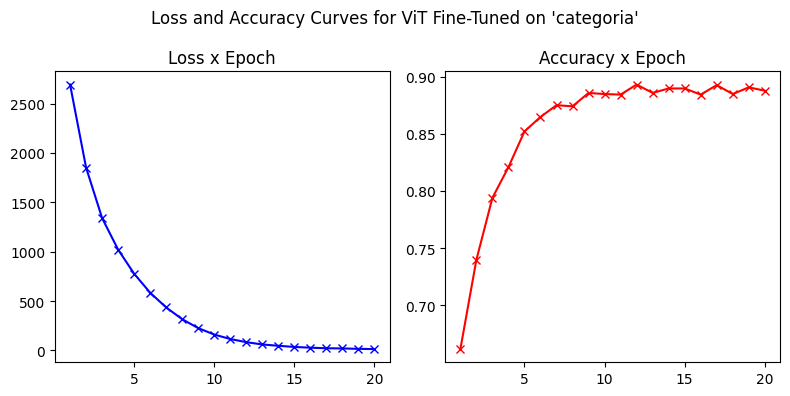

Validation accuracy: 0.89306640625
Validation average per class precision: 0.8643
Validation average per class recall: 0.8774



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.8640081882476807
Test average per class precision: 0.8396
Test average per class recall: 0.8498



In [21]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'frozen_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

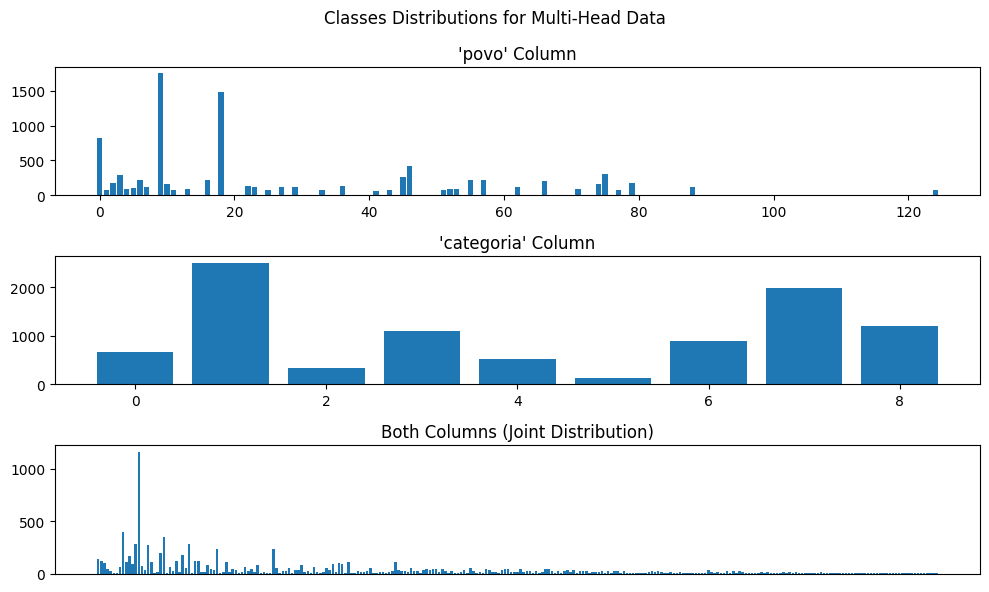

In [22]:
# Getting data that passes both heads' data-filters
povo_set = set(np.array(list(povo_labels.keys()))\
                [np.where(np.isin(np.array(list(povo_labels.values())), \
                np.array(list(povo_filtered_categories.keys()))))[0]])
categoria_set = set(np.array(list(categoria_labels.keys()))\
                    [np.where(np.isin(np.array(list(categoria_labels.values())), \
                    np.array(list(categoria_filtered_categories.keys()))))[0]])
multi_head_keys = [str(x) for x in povo_set.intersection(categoria_set)]

# Studying individual and joint classes' distributions
povo_freq = {}
categoria_freq = {}
multi_freq = {}
for key in multi_head_keys:
    try:
        povo_freq[povo_labels[key]] += 1
    except:
        povo_freq[povo_labels[key]] = 1

    try:
        categoria_freq[categoria_labels[key]] += 1
    except:
        categoria_freq[categoria_labels[key]] = 1

    try:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] += 1
    except:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] = 1

# Utility function to plot rows on data distribution plot
def row_bar_plot(col_freq, name, row, rows=3, cols=1, remove_xticks=False):
    plt.subplot(rows, cols, row)
    plt.bar(list(col_freq.keys()), list(col_freq.values()))
    plt.title(name)

    if remove_xticks:
        plt.xlabel("")
        plt.xticks([])

plt.figure(figsize=(10,6))
plt.suptitle('Classes Distributions for Multi-Head Data')

row_bar_plot(povo_freq, "'povo' Column", 1)
row_bar_plot(categoria_freq, "'categoria' Column", 2)
row_bar_plot(multi_freq, "Both Columns (Joint Distribution)", 3, remove_xticks=True)

plt.tight_layout()
plt.show()

In [23]:
# Because of the even worse degree of unbalanced data on the joint distribution, we balance
# the dataset taking the 'povo' column into consideration and study the new joint distribution
multi_povo_labels = {}
multi_categoria_labels = {}
for key in multi_head_keys:
    multi_povo_labels[key] = povo_labels[key]
    multi_categoria_labels[key] = categoria_labels[key]

# Reusing previous dataset infrastructure to build multi-label dataset
multi_povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_povo_labels)
multi_povo_filtered_categories = multi_povo_categories
multi_povo_filtered_categories_names = {}
for c in categories_keys:
    multi_povo_filtered_categories_names[povo_num_to_name[c]] = multi_povo_categories[c]

multi_categoria_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_categoria_labels)
multi_categoria_filtered_categories = multi_categoria_categories
multi_categoria_filtered_categories_names = {}
for c in categories_keys:
    multi_categoria_filtered_categories_names[categoria_num_to_name[c]] = \
    multi_categoria_categories[c]

Quantile X Data Percentage:
Q-10: 75.00, 96.14% of data
Q-25: 86.00, 91.77% of data
Q-50: 123.00, 80.30% of data
Q-75: 216.50, 64.05% of data
Q-90: 327.40, 47.86% of data

Quantile X Data Percentage:
Q-10: 302.40, 98.63% of data
Q-25: 515.00, 89.42% of data
Q-50: 887.00, 72.71% of data
Q-75: 1203.00, 48.06% of data
Q-90: 2089.00, 26.84% of data



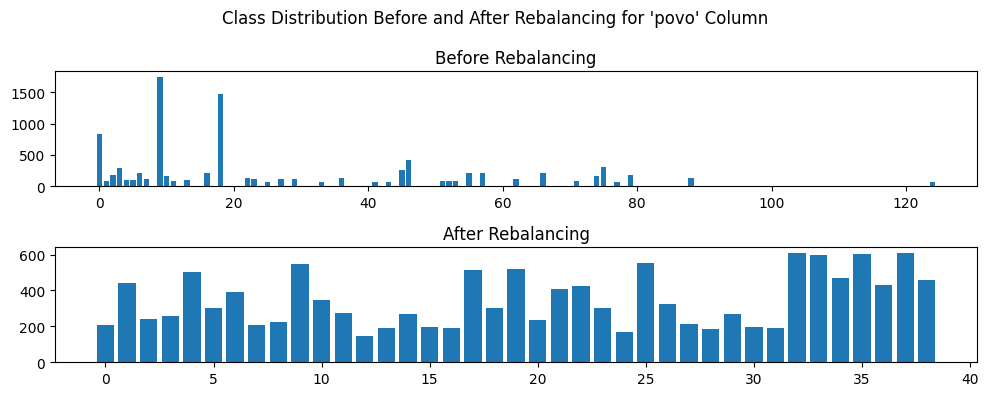

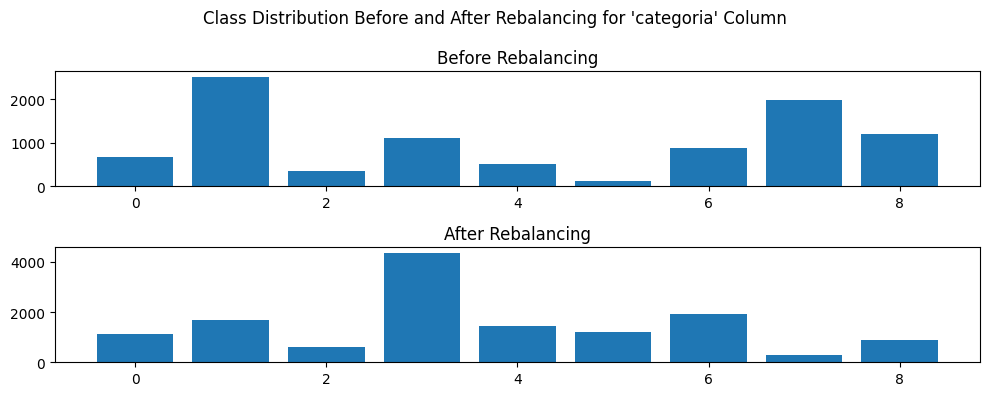

In [24]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         vit_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

# Plotting old and new class distributions
multihead_plot_class_distributions(multi_povo_categories, multi_povo_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'povo')

multihead_plot_class_distributions(multi_categoria_categories, \
                                   multi_categoria_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'categoria')

In [25]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

Training model:   3%|█▌                                           | 1/30 [07:02<3:24:06, 422.29s/it]

Best model saved at epoch 1
Epoch 1, Combined Loss: 1754.4729, Validation Average Accuracy: 0.4907


Training model:   7%|███                                          | 2/30 [14:09<3:18:17, 424.92s/it]

Best model saved at epoch 2
Epoch 2, Combined Loss: 1211.9259, Validation Average Accuracy: 0.5503


Training model:  10%|████▌                                        | 3/30 [21:09<3:10:11, 422.65s/it]

Best model saved at epoch 3
Epoch 3, Combined Loss: 974.5057, Validation Average Accuracy: 0.5796


Training model:  13%|██████                                       | 4/30 [28:10<3:02:57, 422.21s/it]

Best model saved at epoch 4
Epoch 4, Combined Loss: 840.9755, Validation Average Accuracy: 0.5977


Training model:  17%|███████▌                                     | 5/30 [35:09<2:55:30, 421.22s/it]

Best model saved at epoch 5
Epoch 5, Combined Loss: 753.6576, Validation Average Accuracy: 0.6196


Training model:  20%|█████████                                    | 6/30 [42:11<2:48:33, 421.40s/it]

Best model saved at epoch 6
Epoch 6, Combined Loss: 667.9664, Validation Average Accuracy: 0.6426


Training model:  23%|██████████▌                                  | 7/30 [49:12<2:41:27, 421.18s/it]

Best model saved at epoch 7
Epoch 7, Combined Loss: 582.9143, Validation Average Accuracy: 0.6748


Training model:  27%|████████████                                 | 8/30 [56:15<2:34:36, 421.68s/it]

Best model saved at epoch 8
Epoch 8, Combined Loss: 500.1015, Validation Average Accuracy: 0.7002


Training model:  30%|████████████▉                              | 9/30 [1:03:17<2:27:36, 421.73s/it]

Best model saved at epoch 9
Epoch 9, Combined Loss: 413.8816, Validation Average Accuracy: 0.7041


Training model:  33%|██████████████                            | 10/30 [1:10:20<2:20:42, 422.14s/it]

Best model saved at epoch 10
Epoch 10, Combined Loss: 330.4783, Validation Average Accuracy: 0.7524


Training model:  37%|███████████████▍                          | 11/30 [1:17:20<2:13:27, 421.46s/it]

Epoch 11, Combined Loss: 259.6618, Validation Average Accuracy: 0.7485


Training model:  40%|████████████████▊                         | 12/30 [1:24:21<2:06:26, 421.47s/it]

Best model saved at epoch 12
Epoch 12, Combined Loss: 189.4484, Validation Average Accuracy: 0.7705


Training model:  43%|██████████████████▏                       | 13/30 [1:31:24<1:59:31, 421.86s/it]

Epoch 13, Combined Loss: 138.1885, Validation Average Accuracy: 0.7607


Training model:  47%|███████████████████▌                      | 14/30 [1:38:22<1:52:12, 420.75s/it]

Best model saved at epoch 14
Epoch 14, Combined Loss: 103.7752, Validation Average Accuracy: 0.7725


Training model:  50%|█████████████████████                     | 15/30 [1:45:25<1:45:19, 421.28s/it]

Best model saved at epoch 15
Epoch 15, Combined Loss: 70.5719, Validation Average Accuracy: 0.7798


Training model:  53%|██████████████████████▍                   | 16/30 [1:52:26<1:38:20, 421.49s/it]

Epoch 16, Combined Loss: 50.6972, Validation Average Accuracy: 0.7695


Training model:  57%|███████████████████████▊                  | 17/30 [1:59:28<1:31:18, 421.41s/it]

Epoch 17, Combined Loss: 36.4340, Validation Average Accuracy: 0.7793


Training model:  60%|█████████████████████████▏                | 18/30 [2:06:30<1:24:21, 421.82s/it]

Epoch 18, Combined Loss: 31.9846, Validation Average Accuracy: 0.7744


Training model:  63%|██████████████████████████▌               | 19/30 [2:13:30<1:17:11, 421.04s/it]

Best model saved at epoch 19
Epoch 19, Combined Loss: 20.1024, Validation Average Accuracy: 0.7861


Training model:  67%|████████████████████████████              | 20/30 [2:20:29<1:10:06, 420.63s/it]

Epoch 20, Combined Loss: 14.0811, Validation Average Accuracy: 0.7773


Training model:  70%|█████████████████████████████▍            | 21/30 [2:27:33<1:03:13, 421.50s/it]

Epoch 21, Combined Loss: 10.5473, Validation Average Accuracy: 0.7808


Training model:  73%|████████████████████████████████▎           | 22/30 [2:34:36<56:16, 422.10s/it]

Epoch 22, Combined Loss: 14.6474, Validation Average Accuracy: 0.7510


Training model:  77%|█████████████████████████████████▋          | 23/30 [2:41:38<49:14, 422.03s/it]

Epoch 23, Combined Loss: 10.6641, Validation Average Accuracy: 0.7803


Training model:  80%|███████████████████████████████████▏        | 24/30 [2:48:38<42:07, 421.33s/it]

Epoch 24, Combined Loss: 5.9604, Validation Average Accuracy: 0.7783


Training model:  83%|████████████████████████████████████▋       | 25/30 [2:55:41<35:09, 421.96s/it]

Epoch 25, Combined Loss: 16.5375, Validation Average Accuracy: 0.7769


Training model:  87%|██████████████████████████████████████▏     | 26/30 [3:02:39<28:03, 420.76s/it]

Epoch 26, Combined Loss: 4.5591, Validation Average Accuracy: 0.7793


Training model:  90%|███████████████████████████████████████▌    | 27/30 [3:09:40<21:02, 420.85s/it]

Epoch 27, Combined Loss: 3.7765, Validation Average Accuracy: 0.7822


Training model:  93%|█████████████████████████████████████████   | 28/30 [3:16:40<14:01, 420.50s/it]

Epoch 28, Combined Loss: 14.9157, Validation Average Accuracy: 0.7729


Training model:  93%|█████████████████████████████████████████   | 28/30 [3:23:42<14:33, 436.53s/it]

Early-stopping training!


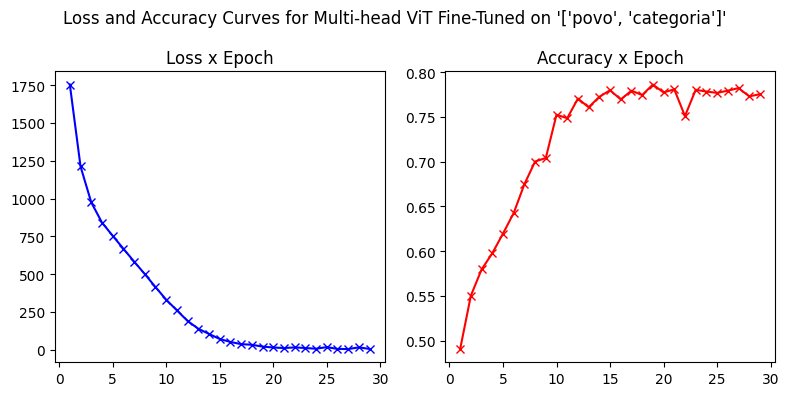

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:719: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation 'povo' head accuracy: 0.697265625
Validation 'categoria' head accuracy: 0.87548828125
Validation average accuracy: 0.7861328125

Validation 'povo' head average per class precision: 0.7077
Validation 'povo' head average per class recall: 0.6721

Validation 'categoria' head average per class precision: 0.8664
Validation 'categoria' head average per class recall: 0.8433

Test 'povo' head accuracy: 0.7180384993553162
Test 'categoria' head accuracy: 0.9124343395233154
Test average accuracy: 0.8154296875

Test 'povo' head average per class precision: 0.7073
Test 'povo' head average per class recall: 0.6891

Test 'categoria' head average per class precision: 0.9176
Test 'categoria' head average per class recall: 0.9074



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:50<00:00,  7.39s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
# Training multi-head model on balanced dataset to see the difference in results
batch_size = 16
epochs = 30
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = ViTClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=3e-6)
model_name = 'multihead_vit'
column_names = ['povo', 'categoria']
arch_name = 'ViT'
head_weights = [0.3, 0.7]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

multihead_vit_trimap, multihead_vit_tsne, multihead_vit_umap, \
multihead_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [27]:
# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

multihead_vit_trimap = normalize(multihead_vit_trimap, norm_factor)
multihead_vit_tsne = normalize(multihead_vit_tsne, norm_factor)
multihead_vit_umap = normalize(multihead_vit_umap, norm_factor)

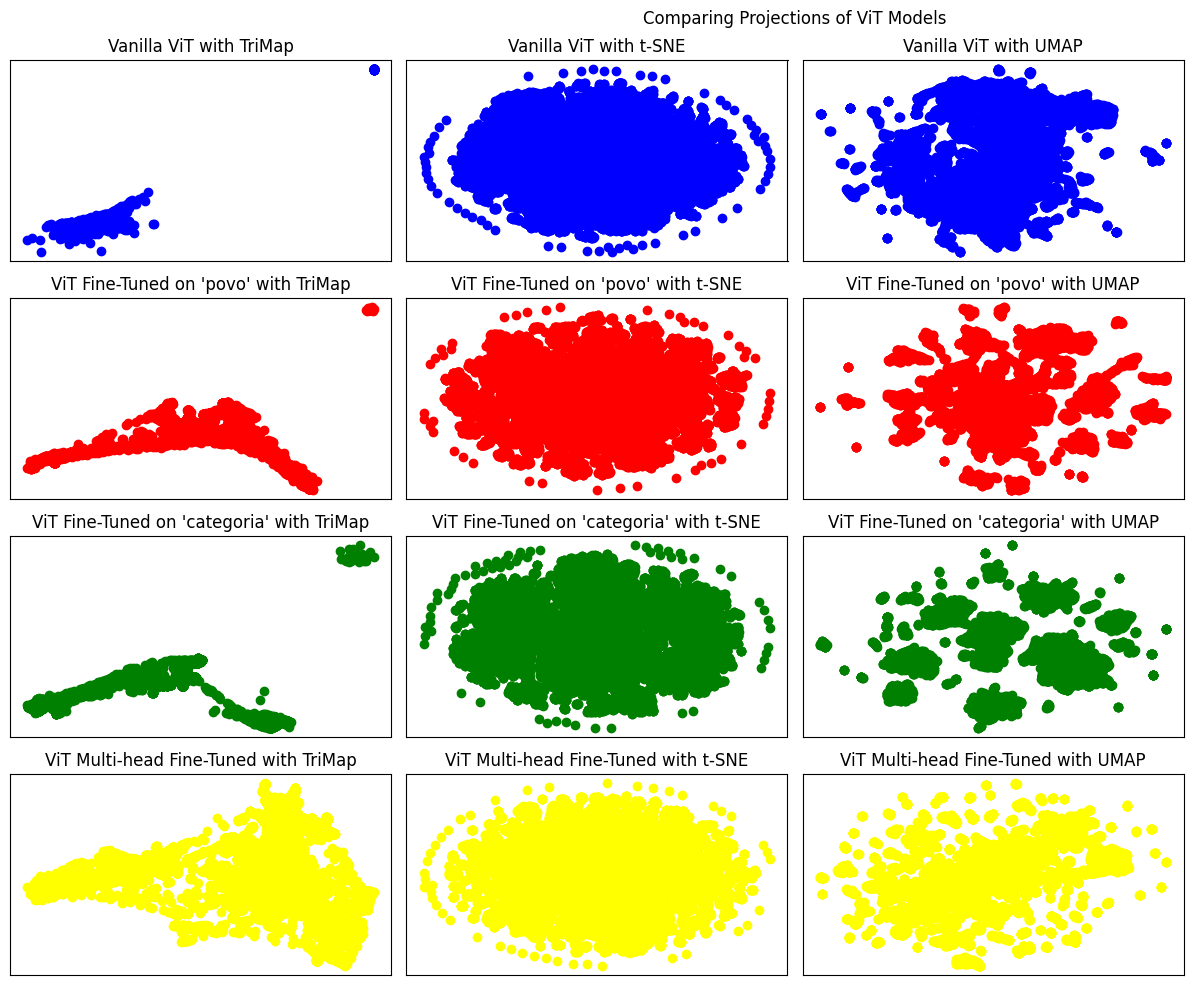

In [32]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=4, cols=4):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(16,10))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
projs = [vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap]
proj_names = ['Vanilla ViT with TriMap', 'Vanilla ViT with t-SNE', 'Vanilla ViT with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b')

# Plotting ViT fine-tuned on 'povo' projections
projs = [povo_vit_trimap, povo_vit_tsne, povo_vit_umap]
proj_names = ["ViT Fine-Tuned on 'povo' with TriMap", "ViT Fine-Tuned on 'povo' with t-SNE", \
              "ViT Fine-Tuned on 'povo' with UMAP"]
row_scatter_plot(projs, proj_names, 2, 'r')

# Plotting ViT fine-tuned on 'categoria' projections
projs = [categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap]
proj_names = ["ViT Fine-Tuned on 'categoria' with TriMap", \
              "ViT Fine-Tuned on 'categoria' with t-SNE", \
              "ViT Fine-Tuned on 'categoria' with UMAP"]
row_scatter_plot(projs, proj_names, 3, 'g')

# Plotting ViT fine-tuned on 'povo' and 'categoria' (multi-head) projections
projs = [multihead_vit_trimap, multihead_vit_tsne, multihead_vit_umap]
proj_names = ["ViT Multi-head Fine-Tuned with TriMap", \
              "ViT Multi-head Fine-Tuned with t-SNE", \
              "ViT Multi-head Fine-Tuned with UMAP"]
row_scatter_plot(projs, proj_names, 4, 'yellow')

plt.tight_layout()
plt.show()

### Visualizing Clusters

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:818: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


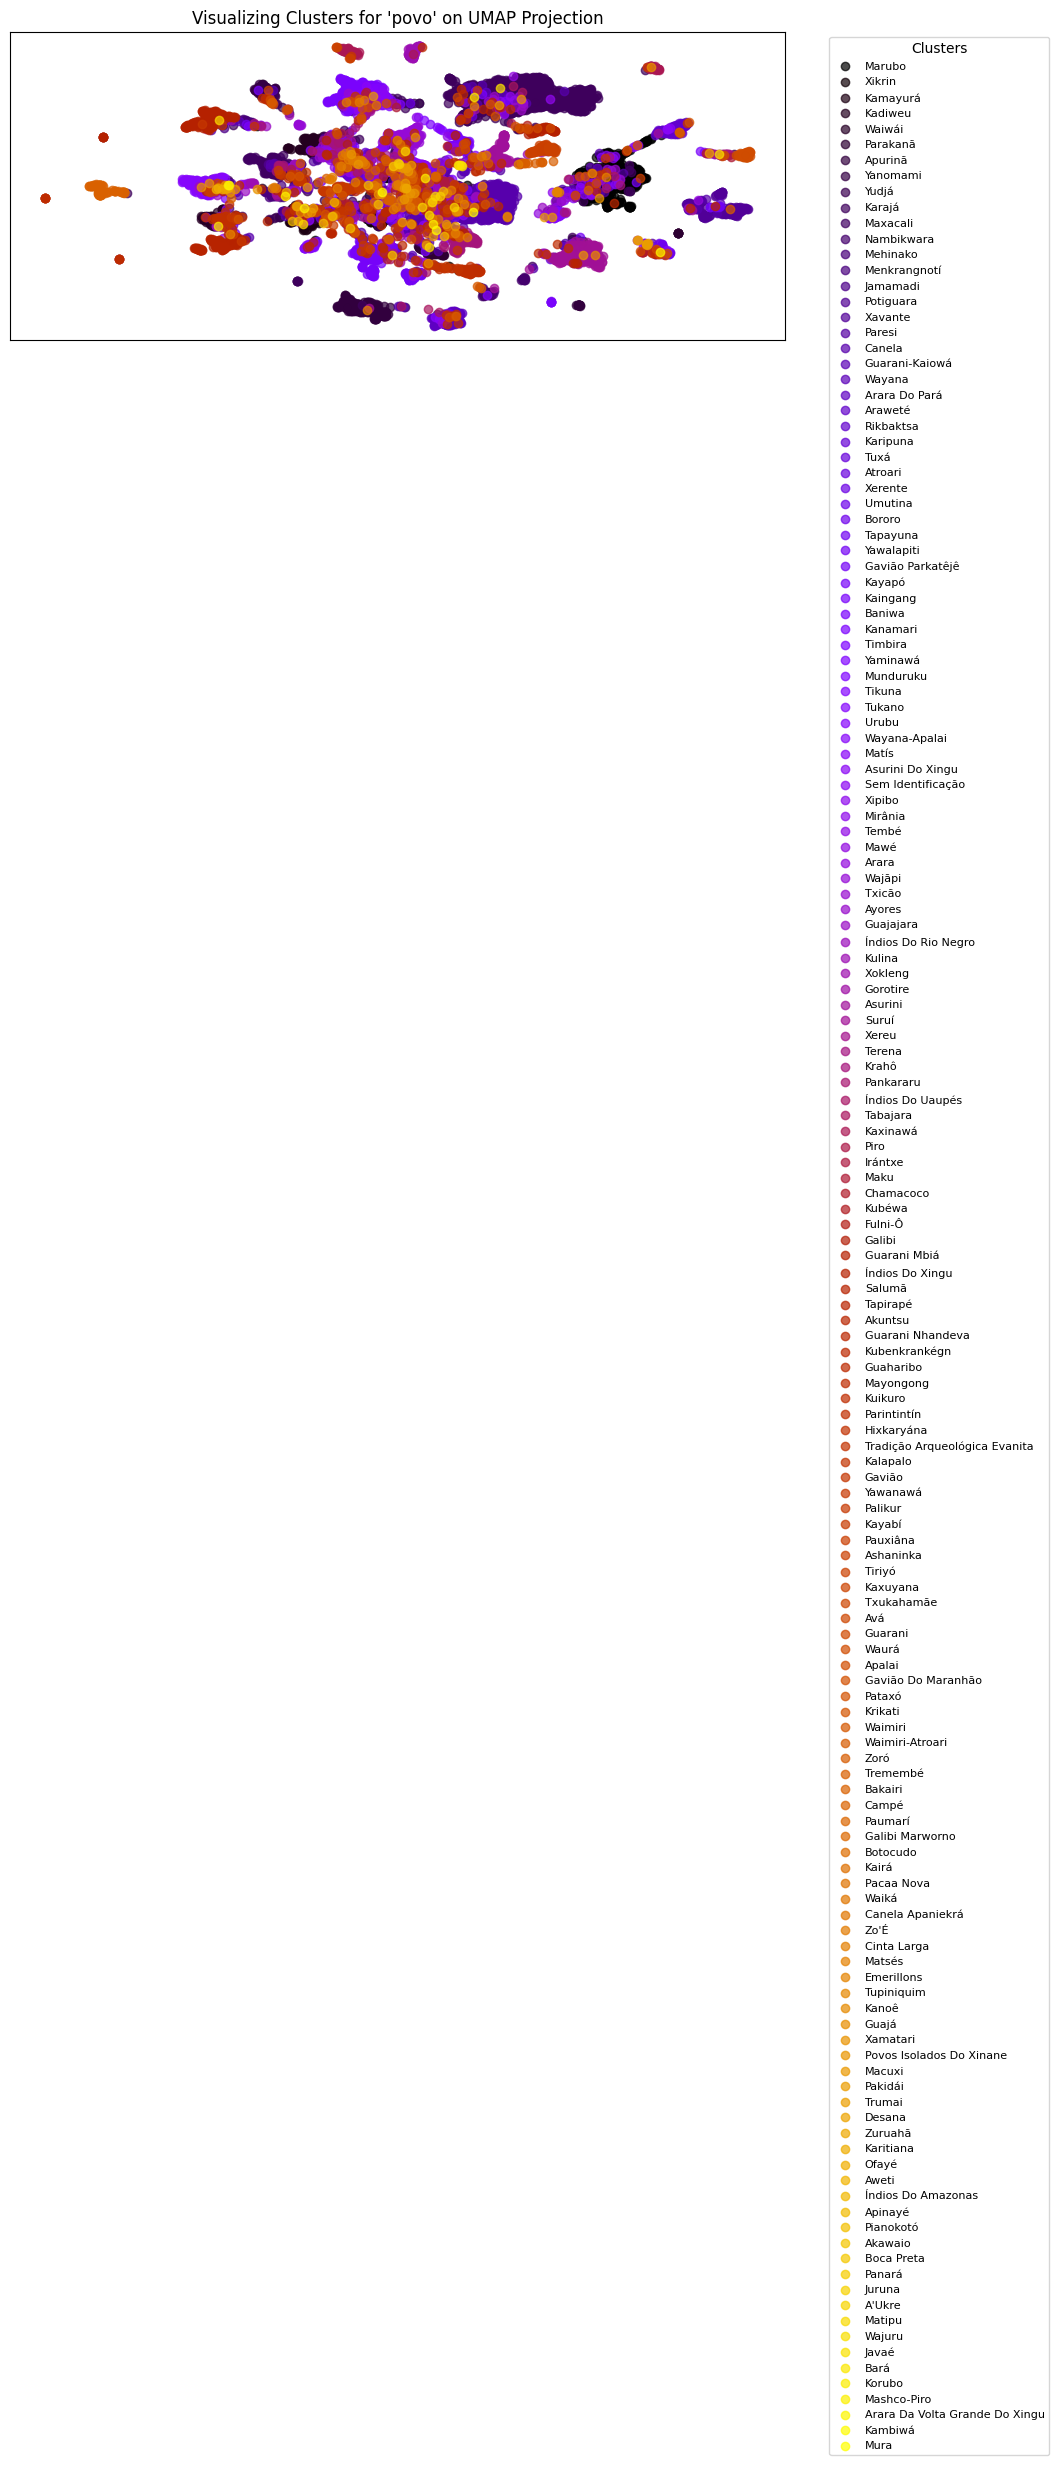

In [33]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_vit_umap, povo_image_indices, 'povo', 'UMAP')

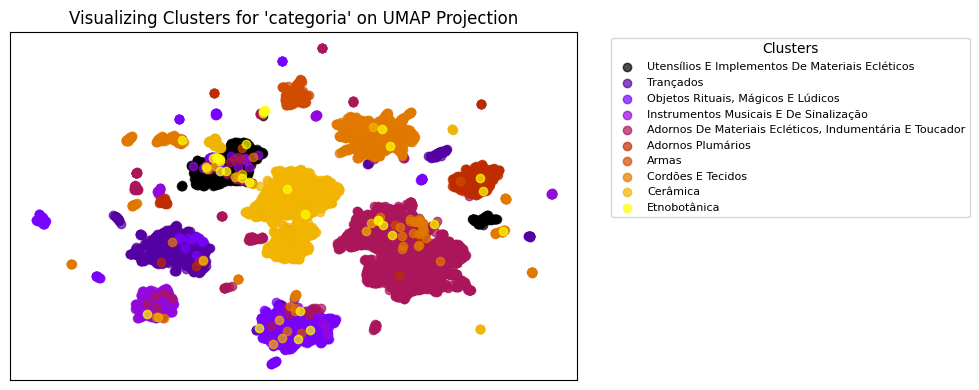

In [34]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_vit_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

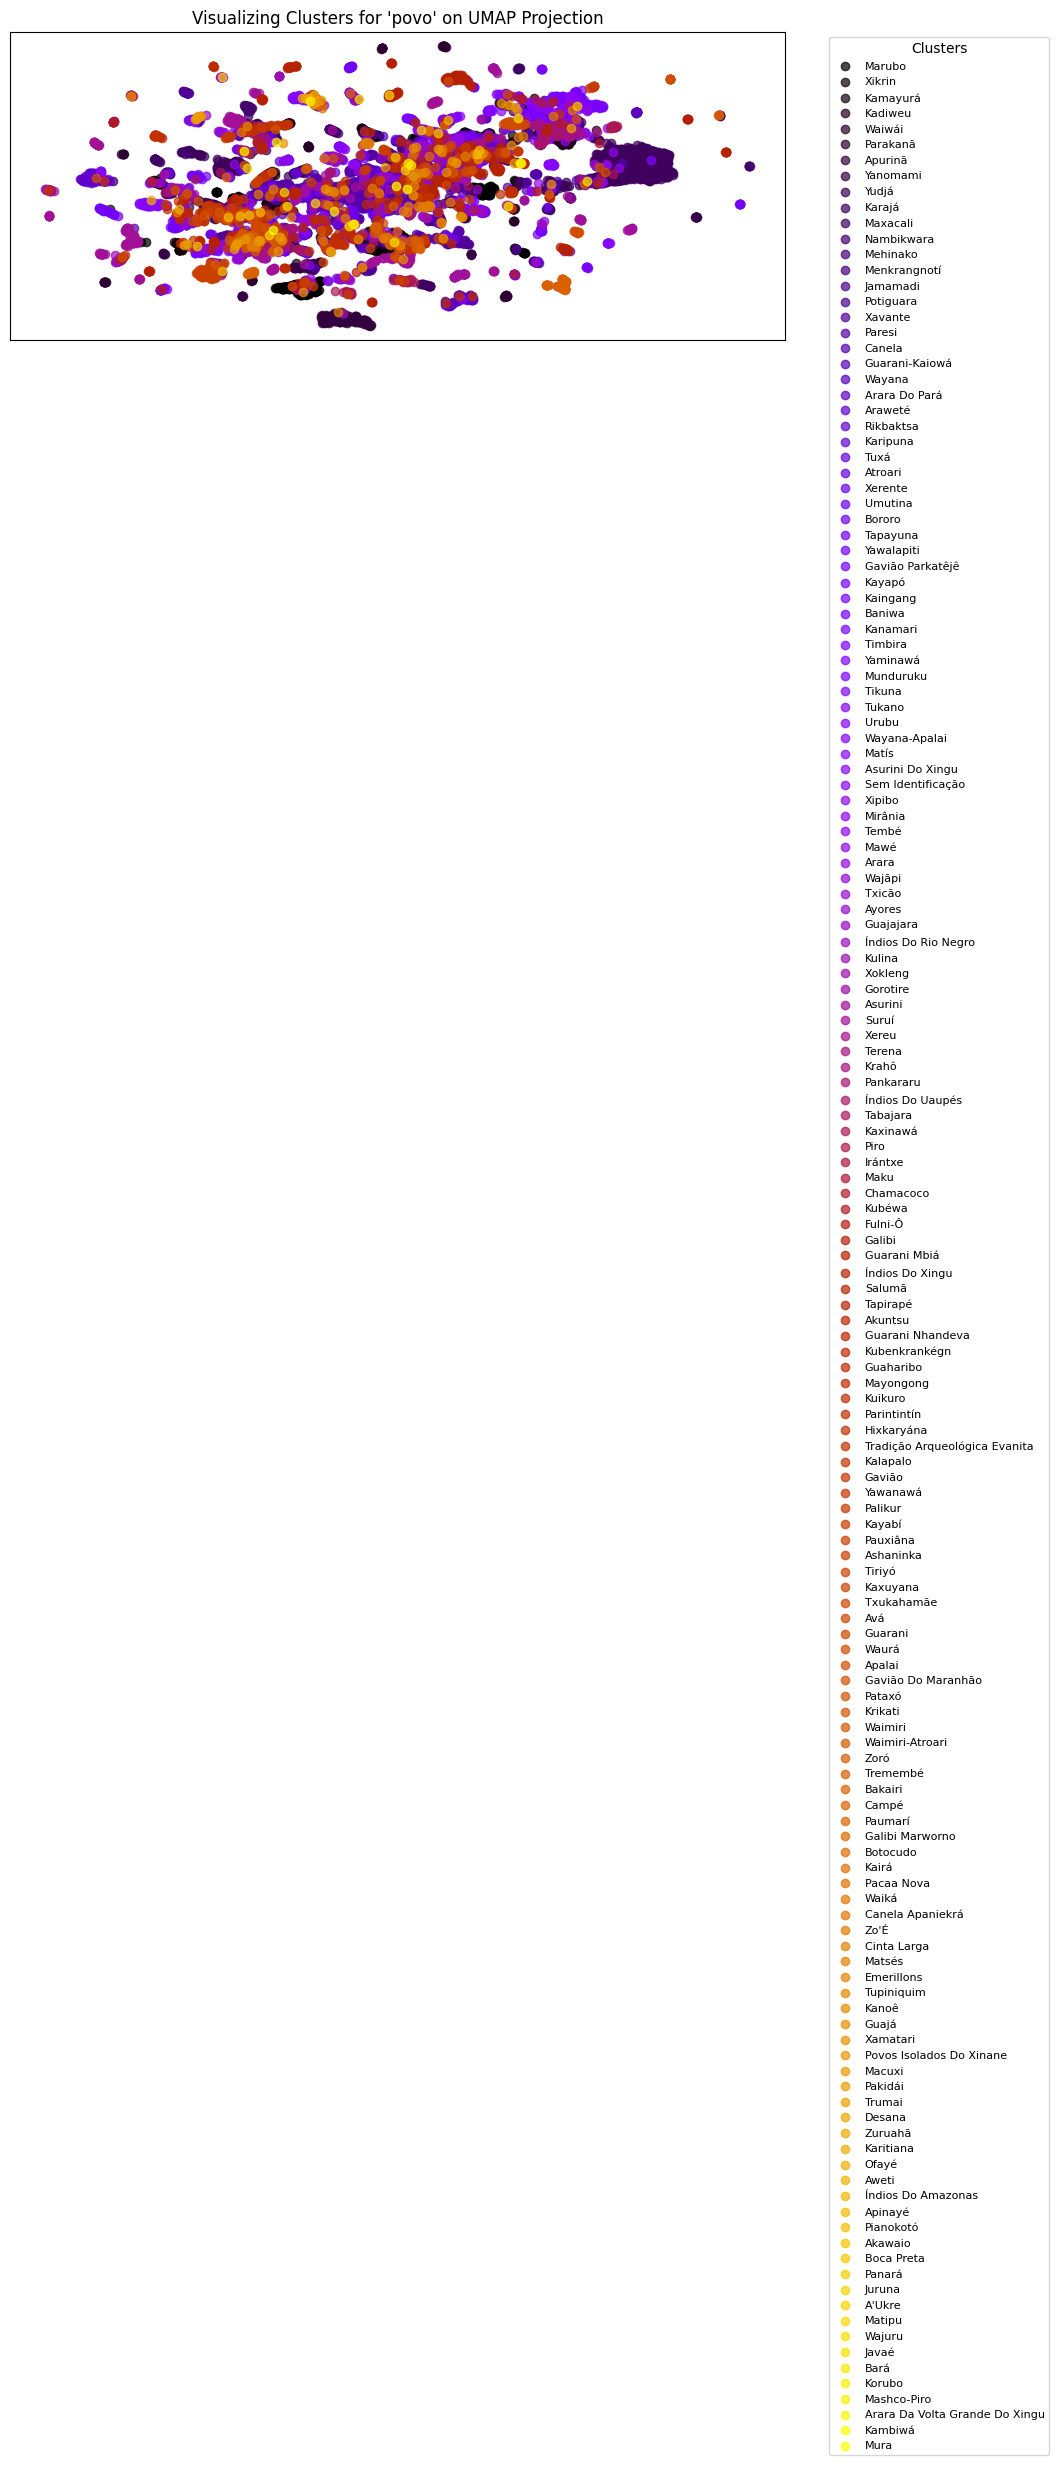

In [35]:
# Visualizing 'povo' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_vit_umap, multihead_image_indices, \
                     'povo', 'UMAP')

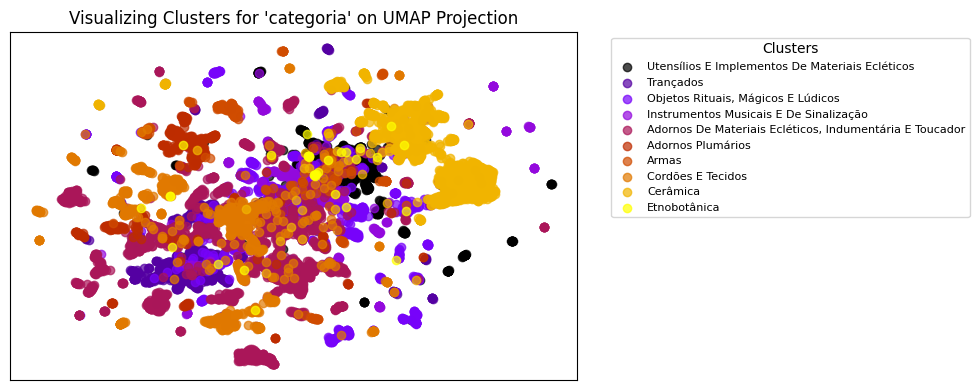

In [36]:
# Visualizing 'categoria' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_vit_umap, multihead_image_indices, \
                     'categoria', 'UMAP')

In [50]:
# Saving outputs for visualization tool
_ = saving_outputs(filtered_df, povo_labels, vanilla_vit_umap, vanilla_image_indices, \
                   save_file='vanilla_vit.csv', no_clusters=True)

_ = saving_outputs(filtered_df, povo_labels, povo_vit_umap, povo_image_indices, 'povo', \
                   'povo_vit.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_vit_umap, \
                   categoria_image_indices, 'categoria', 'categoria_vit.csv')

_ = saving_outputs(filtered_df, povo_labels, multihead_vit_umap, \
                   multihead_image_indices, save_file='multihead_vit.csv', no_clusters=True)

## DINOv2

### Pre-Trained Embedding Space

In [ ]:
from transformers import AutoImageProcessor, AutoModel

# Rebuilding dataset with DINO transform and dataloader with smaller batch_size because of 
# the model's size
dino_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
povo_dataset = ImageDataset(povo_labels, transform=dino_transform, augment=False)
povo_dataloader = DataLoader(povo_dataset, batch_size=16, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Loading model and pre-processor
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.to(device)

# Projecting data onto the off-the-shelf pre-trained embedding space from DINOv2
image_embeddings, vanilla_image_indices = get_embeddings(model, povo_dataloader, device, \
                                                         model_name='dino')
image_embeddings = np.concatenate(image_embeddings, axis=0)
vanilla_image_indices = np.concatenate(vanilla_image_indices, axis=0)

# Computing data reduced-dimensionality projections
_, _, vanilla_dino_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

### Fine-Tuning Embedding Space

In [ ]:
# Creating our own DINO classifier head for fine-tuning
class DINOClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(DINOClassifier, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-base')
        self.classifier1 = nn.Linear(self.dino.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.dino.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)
    
    def forward(self, x):
        outputs = self.dino(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.dino.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [ ]:
# Recreating datasets for proper training and testing
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=dino_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=dino_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'dino_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                        batch_size, epochs, num_classes, model, criterion, \
                                        opt, model_name, column_name, \
                                        architecture_name='DINOv2')
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            dino_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'balanced_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset, architecture_name='DINOv2')

# _, _, \
# povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
#                                                                    device, 'dino')

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 9
model = DINOClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'frozen_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, povo_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                   device, 'dino')

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [ ]:
# Now creating the 'categoria' dataset
categoria_dataset = ImageDataset(categoria_labels, transform=dino_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=8, shuffle=True, \
                                  num_workers=0, pin_memory=True)

# Recreating datasets for proper training and testing
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=dino_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, transform=dino_transform, \
                                      augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'dino_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name, \
                                         architecture_name='DINOv2')
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, dino_transform, \
                               threshold_multiplier, 'categoria')

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

# _, _, \
# categoria_dino_umap, categoria_image_indices = \
# compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = DINOClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
categoria_dino_umap, categoria_image_indices = \
compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

In [ ]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         dino_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

In [ ]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

In [ ]:
import image_training_utils
importlib.reload(image_training_utils)
from image_training_utils import *

# Training multi-head model on balanced dataset to see the difference in results
batch_size = 8
epochs = 20
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = DINOClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'multihead_dino'
column_names = ['povo', 'categoria']
arch_name = 'DINOv2'
head_weights = [0.5, 0.5]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

_, _, multihead_dino_umap, \
multihead_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [ ]:
# Normalizing data for later plot on tool
vanilla_dino_umap = normalize(vanilla_dino_umap, norm_factor)
povo_dino_umap = normalize(povo_dino_umap, norm_factor)
categoria_dino_umap = normalize(categoria_dino_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing ViT and DINO Projections')

# Plotting all ViT projections
projs = [vanilla_vit_umap, povo_vit_umap, categoria_vit_umap, multihead_vit_umap]
proj_names = ["Vanilla ViT", "'povo' ViT", "'categoria' ViT", "Multi-head ViT"]
row_scatter_plot(projs, proj_names, 1, 'b', 2, 4)

# Plotting all DINO projections
projs = [vanilla_dino_umap, povo_dino_umap, categoria_dino_umap, multihead_dino_umap]
proj_names = ["Vanilla DINO", "'povo' DINO", "'categoria' DINO", "Multi-head DINO"]
row_scatter_plot(projs, proj_names, 2, 'r', 2, 4)

plt.tight_layout()
plt.show()

### Visualizing Clusters

In [ ]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_dino_umap, povo_image_indices, 'povo', 'UMAP')

In [ ]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_dino_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

In [ ]:
# Visualizing 'povo' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_dino_umap, multihead_image_indices, \
                     'povo', 'UMAP')

In [ ]:
# Visualizing 'categoria' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_dino_umap, multihead_image_indices, \
                     'categoria', 'UMAP')

In [ ]:
# Saving outputs for visualization tool
_ = saving_outputs(filtered_df, povo_labels, vanilla_dino_umap, vanilla_image_indices, \
                   save_file='vanilla_dino.csv', no_clusters=True)

_ = saving_outputs(filtered_df, povo_labels, povo_dino_umap, povo_image_indices, 'povo', \
                   'povo_dino.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_dino_umap, \
                   categoria_image_indices, 'categoria', 'categoria_dino.csv')

_ = saving_outputs(filtered_df, povo_labels, multihead_dino_umap, \
                   multihead_image_indices, save_file='multihead_dino.csv', no_clusters=True)